In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:46343")
client

<Client: 'tcp://127.0.0.1:46343' processes=8 threads=32, memory=125.85 GiB>

In [2]:
import numpy as np
import xarray as xr
import pandas as pd
from xhistogram.xarray import histogram as xhist
from xgcm.grid import Grid
import xrft
import s3fs
import gsw

import glob

import gcm_filters

import os.path as op

from xeofs.models import EOF
from pydmd import DMD, BOPDMD, MrDMD
from pydmd.mrcosts import mrCOSTS
from pydmd.preprocessing import hankel_preprocessing
from pydmd.plotter import plot_eigs, plot_summary

from matplotlib import ticker
import matplotlib.colors as clr
import matplotlib.pyplot as plt
plt.rcParams['pcolor.shading'] = 'auto'
%matplotlib inline

In [3]:
sdir = '/tank/spectre/tuchida/DMD/'

In [4]:
from validate_catalog import all_params
params_dict, cat = all_params()
entries = list(cat._entries.keys())
entries

['GIGATL', 'HYCOM25', 'HYCOM50', 'eNATL60', 'FESOM', 'ORCA36', 'FIO-COM32']

In [7]:
hycom01s = cat.HYCOM50(region='1_GS', datatype='surf', season='aso', decode_times=False
                      ).to_dask()
hycom01d = cat.HYCOM50(region='1_GS', datatype='int', season='aso', decode_times=False
                      ).to_dask()
hycom50_grids = xr.open_dataset('/tank/spectre/tuchida/SWOT/Models/HYCOM50/HYCOM50_grid_GS_all.nc'
                               )

In [6]:
SSU_d = hycom01d.u3.isel(lay=0)
SSV_d = hycom01d.v3.isel(lay=0)

In [19]:
u = SSU_d.copy()
v = SSV_d.copy()
hycom_copy = hycom01d.drop(['h3','t3','s3','u3','v3']).copy()
Ny = len(hycom50_grids.lat)
Nx = len(hycom50_grids.lon)

## Make metadata C-grid again ##

hycom_copy['u'] = xr.DataArray(u.data, dims=['time','lat','lonG'],
                               coords={'time':hycom01d.time,
                                       'lat':hycom01d.lat,
                                       'lonG':np.arange(-.5,Nx-.5,1)}
                              ).reset_coords(drop=True)
hycom_copy['v'] = xr.DataArray(v.data, dims=['time','latG','lon'],
                               coords={'time':hycom01d.time,
                                       'latG':np.arange(-.5,Ny-.5,1),
                                       'lon':hycom01d.lon}
                              ).reset_coords(drop=True)

coords={'T':{'center':'time'},
        'X':{'center':'lon', 'left':'lonG'}, 
        'Y':{'center':'lat', 'left':'latG'},
       }

grid = Grid(hycom_copy, coords=coords, periodic=[])

mask = xr.DataArray(~np.ma.masked_invalid(hycom01s.ssh.isel(time=0)).mask,
                    dims=hycom01s.ssh.isel(time=0).dims,
                    coords=hycom01s.ssh.isel(time=0).coords
                   ).reset_coords(drop=True)
# grid info centered at T-points
wet_mask_t = mask.copy()
wet_mask_t[dict(lon=-1)] = 0.
wet_mask_t[dict(lon=0)] = 0.
wet_mask_t[dict(lat=-1)] = 0.
wet_mask_t[dict(lat=0)] = 0.

mask = xr.DataArray(~np.ma.masked_invalid(grid.interp(hycom_copy.u,'Y',boundary='extend'
                                                     ).isel(time=0)).mask,
                    dims=hycom01s.ssh.isel(time=0).dims,
                    coords=hycom01s.ssh.isel(time=0).coords
                   ).reset_coords(drop=True)
# grid info centered at vorticity points
wet_mask_q = mask.copy()
wet_mask_q[dict(lon=-1)] = 0.
wet_mask_q[dict(lon=0)] = 0.
wet_mask_q[dict(lat=-1)] = 0.
wet_mask_q[dict(lat=0)] = 0.

# grid info centered at T-points
dxT = xr.DataArray(hycom50_grids.pscx.data, dims=hycom01s.ssh.isel(time=0).dims, 
                   coords=hycom01s.ssh.isel(time=0).coords
                  ).reset_coords(drop=True)
dyT = xr.DataArray(hycom50_grids.pscy.data, dims=hycom01s.ssh.isel(time=0).dims, 
                   coords=hycom01s.ssh.isel(time=0).coords
                  ).reset_coords(drop=True)
# grid info centered at U-points
dxCu = xr.DataArray(hycom50_grids.uscx.data, dims=['lat','lonG'],
                    coords={'lat':hycom_copy.lat,'lonG':hycom_copy.lonG}
                   ).swap_dims({"lonG": "lon"}).reset_coords(drop=True)
dyCu = xr.DataArray(hycom50_grids.uscy, dims=['lat','lonG'],
                    coords={'lat':hycom_copy.lat,'lonG':hycom_copy.lonG}
                   ).swap_dims({"lonG": "lon"}).reset_coords(drop=True)
area_u = dxCu * dyCu
# grid info centered at V-points
dxCv = xr.DataArray(hycom50_grids.vscx, dims=['latG','lon'],
                    coords={'latG':hycom_copy.latG,'lon':hycom_copy.lon}
                   ).swap_dims({"latG": "lat"}).reset_coords(drop=True)
dyCv = xr.DataArray(hycom50_grids.vscy, dims=['latG','lon'],
                    coords={'latG':hycom_copy.latG,'lon':hycom_copy.lon}
                   ).swap_dims({"latG": "lat"}).reset_coords(drop=True)
area_v = dxCv * dyCv
# grid info centered at Q-points
dxBu = xr.DataArray(hycom50_grids.qscx, dims=['latG','lonG'],
                    coords={'latG':hycom_copy.latG,'lonG':hycom_copy.lonG}
                   ).swap_dims({"lonG": "lon", "latG": "lat"}).reset_coords(drop=True)
dyBu = xr.DataArray(hycom50_grids.qscy, dims=['latG','lonG'],
                    coords={'latG':hycom_copy.latG,'lonG':hycom_copy.lonG}
                   ).swap_dims({"lonG": "lon", "latG": "lat"}).reset_coords(drop=True)

dx_min = min(dxT.where(wet_mask_t).min(), dyT.where(wet_mask_t).min())
dx_min = dx_min.values

kappa_iso = xr.ones_like(dxT)
kappa_aniso = xr.zeros_like(dyT)

filter_scale = 10_000

filter_visc = gcm_filters.Filter(
        filter_scale=filter_scale,
        dx_min=dx_min,
        filter_shape=gcm_filters.FilterShape.GAUSSIAN,
        grid_type=gcm_filters.GridType.VECTOR_C_GRID,
        grid_vars={
            'wet_mask_t': wet_mask_t.chunk({'lat':-1,'lon':-1}), 
            'wet_mask_q': wet_mask_q.chunk({'lat':-1,'lon':-1}),
            'dxT': dxT.chunk({'lat':-1,'lon':-1}), 
            'dyT': dyT.chunk({'lat':-1,'lon':-1}), 
            'dxCu': dxCu.chunk({'lat':-1,'lon':-1}), 
            'dyCu': dyCu.chunk({'lat':-1,'lon':-1}), 
            'area_u': area_u.chunk({'lat':-1,'lon':-1}), 
            'dxCv': dxCv.chunk({'lat':-1,'lon':-1}), 
            'dyCv': dyCv.chunk({'lat':-1,'lon':-1}), 
            'area_v': area_v.chunk({'lat':-1,'lon':-1}),
            'dxBu': dxBu.chunk({'lat':-1,'lon':-1}), 
            'dyBu': dyBu.chunk({'lat':-1,'lon':-1}),
            'kappa_iso': kappa_iso.chunk({'lat':-1,'lon':-1}), 
            'kappa_aniso': kappa_aniso.chunk({'lat':-1,'lon':-1})
        }
    )

ds_tmp = xr.Dataset()  # temporary dataset with swapped dimensions
ds_tmp['u'] = hycom_copy.u
ds_tmp['v'] = hycom_copy.v
ds_tmp['u'] = ds_tmp['u'].swap_dims({'lonG':'lon'})
ds_tmp['v'] = ds_tmp['v'].swap_dims({'latG':'lat'})
(u_filtered, v_filtered) = filter_visc.apply_to_vector(ds_tmp.u, ds_tmp.v, 
                                                       dims=['lat', 'lon']
                                                      )
u_filtered = u_filtered.swap_dims({"lon":"lonG"})
u_filtered.coords['lonG'] = np.arange(-.5,Nx-.5,1)
u_filtered = u_filtered.isel(lonG=slice(1,-1),lat=slice(1,-1))
v_filtered = v_filtered.swap_dims({"lat":"latG"})
v_filtered.coords['latG'] = np.arange(-.5,Ny-.5,1)
v_filtered = v_filtered.isel(latG=slice(1,-1),lon=slice(1,-1))

dsave = u_filtered.to_dataset(name='u')
dsave['v'] = v_filtered
dsave.chunk({'time':2,'lat':100,'latG':100,'lon':100,'lonG':100}).to_zarr(
              '/tank/spectre/tuchida/SWOT/Models/HYCOM50/UV_daily_10km.zarr', 
              mode='w')

In [30]:
dsuv = xr.open_zarr('/tank/spectre/tuchida/SWOT/Models/HYCOM50/UV_daily_10km.zarr',
                    decode_times=False
                   ).isel(lat=slice(240,500),lon=slice(-280,None),
                          latG=slice(240,500),lonG=slice(-280,None)
                         )
grid = Grid(dsuv, periodic=[],
            coords={'Y':{'center':'lat','left':'latG'},
                    'X':{'center':'lon','left':'lonG'}},
           )

hycom_grid = xr.open_dataset(
    '/tank/spectre/tuchida/SWOT/Models/HYCOM50/HYCOM50_grid_GS_all.nc'
                            ).isel(lat=slice(240,500),lon=slice(-280,None))

dsuv

<xarray.Dataset>
Dimensions:  (lat: 260, latG: 260, lon: 280, lonG: 280, time: 92)
Coordinates:
  * lat      (lat) int64 241 242 243 244 245 246 247 ... 495 496 497 498 499 500
  * latG     (latG) float64 240.5 241.5 242.5 243.5 ... 496.5 497.5 498.5 499.5
  * lon      (lon) int64 222 223 224 225 226 227 228 ... 496 497 498 499 500 501
  * lonG     (lonG) float64 221.5 222.5 223.5 224.5 ... 497.5 498.5 499.5 500.5
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 82 83 84 85 86 87 88 89 90 91
Data variables:
    u        (time, lat, lonG) float32 dask.array<chunksize=(2, 60, 79), meta=np.ndarray>
    v        (time, latG, lon) float32 dask.array<chunksize=(2, 60, 79), meta=np.ndarray>

In [23]:
hycomf  = xr.apply_ufunc(gsw.f, hycom_grid.plat, dask='parallelized')
hycomfq = xr.apply_ufunc(gsw.f, hycom_grid.qlat, dask='parallelized')
hycomfu = xr.apply_ufunc(gsw.f, hycom_grid.ulat, dask='parallelized')
hycomfv = xr.apply_ufunc(gsw.f, hycom_grid.vlat, dask='parallelized')
hycomf

<xarray.DataArray 'plat' (lat: 260, lon: 280)>
array([[8.16740126e-05, 8.16740126e-05, 8.16740126e-05, ...,
        8.16740126e-05, 8.16740126e-05, 8.16740126e-05],
       [8.17089468e-05, 8.17089468e-05, 8.17089468e-05, ...,
        8.17089468e-05, 8.17089468e-05, 8.17089468e-05],
       [8.17438662e-05, 8.17438662e-05, 8.17438662e-05, ...,
        8.17438662e-05, 8.17438662e-05, 8.17438662e-05],
       ...,
       [9.02029385e-05, 9.02029385e-05, 9.02029385e-05, ...,
        9.02029385e-05, 9.02029385e-05, 9.02029385e-05],
       [9.02343708e-05, 9.02343708e-05, 9.02343708e-05, ...,
        9.02343708e-05, 9.02343708e-05, 9.02343708e-05],
       [9.02657811e-05, 9.02657811e-05, 9.02657811e-05, ...,
        9.02657811e-05, 9.02657811e-05, 9.02657811e-05]])
Dimensions without coordinates: lat, lon

In [24]:
grav= 9.807

def diff(a, shift, axis):
    return a - np.roll(a, shift, axis)

In [25]:
def q_vort(u, v, dxq, dyq, dxu, dyv):
    return (
        diff(v * dyv, 1, axis=-1)
        - diff(u * dxu, 1, axis=-2)
    ) / (dxq * dyq)

def q_div(u, v, dxp, dyp, dyu, dxv):
    return (
        diff(v * dxv, 1, axis=-2)
        + diff(u * dyu, 1, axis=-1)
    ) / (dxp * dyp)

def q_str(u, v, dxp, dyp, dxq, dyq, dxu, dyu, dxv, dyv):
    str1 = (diff(u * dyu, 1, axis=-1)
            - diff(v * dxv, 1, axis=-2)
           ) / (dyp * dxp)
    str2 = (diff(u * dxu, 1, axis=-2)
            + diff(v * dyv, 1, axis=-1)
           ) / (dyq * dxq)
    str1 = .25*(str1 
                + np.roll(str1,1,-1) 
                + np.roll(str1,1,-2)
                + np.roll(np.roll(str1,1,-1),1,-2)
               )
    return np.sqrt(str1**2
        + str2**2
    )

In [33]:
vor = (grid.diff(dsuv.v*hycom_grid.vscy.data,'X',boundary='extend')
       - grid.diff(dsuv.u*hycom_grid.uscx.data,'Y',boundary='extend')
      ) / (hycom_grid.qscx * hycom_grid.qscy).data
str = np.sqrt(
    grid.interp(grid.interp(((grid.diff(dsuv.u*hycom_grid.uscy.data,'X',boundary='extend')
     - grid.diff(dsuv.v*hycom_grid.vscx.data,'Y',boundary='extend')
    ) / (hycom_grid.pscx * hycom_grid.pscy).data) ** 2,'X',boundary='extend'),'Y',boundary='extend')
    + ((grid.diff(dsuv.v*hycom_grid.vscy.data,'X',boundary='extend')
       + grid.diff(dsuv.u*hycom_grid.uscx.data,'Y',boundary='extend')
       ) / (hycom_grid.qscx * hycom_grid.qscy).data) ** 2
)
str
# vor = xr.apply_ufunc(
#     q_vort,
#     dsuv.u.swap_dims({"lonG":"lon"}), 
#     dsuv.v.swap_dims({"latG":"lat"}), 
#     hycom_grid.pscx, hycom_grid.pscy,
#     hycom_grid.uscy, hycom_grid.vscx,
#     input_core_dims = 6 * [['lat', 'lon']],    # 4 inputs
#     output_core_dims = [['lat', 'lon']],
#     output_dtypes=[hycomfq.dtype],
#     dask="parallelized"
# ).isel(lat=slice(2,-2),lon=slice(2,-2)).reset_coords(drop=True).rename('vort')
# div = xr.apply_ufunc(
#     q_div,
#     dsuv.u, 
#     dsuv.v,  
#     hycom_grid.qscx, hycom_grid.qscy,
#     hycom_grid.uscx, hycom_grid.vscy,
#     input_core_dims = 6 * [['lat', 'lon']],    # 4 inputs
#     output_core_dims = [['lat', 'lon']],
#     output_dtypes=[hycomfq.dtype],
#     dask="parallelized"
# ).isel(lat=slice(2,-2),lon=slice(2,-2)).reset_coords(drop=True).rename('div')
# str = xr.apply_ufunc(
#     q_str,
#     dsuv.u, 
#     dsuv.v, 
#     hycom_grid.pscx, hycom_grid.pscy,
#     hycom_grid.qscx, hycom_grid.qscy,
#     hycom_grid.uscx, hycom_grid.uscy,
#     hycom_grid.vscx, hycom_grid.vscy,
#     input_core_dims = 10 * [['lat', 'lon']],   # 4 inputs
#     output_core_dims = [['lat', 'lon']],
#     output_dtypes=[hycomfq.dtype],
#     dask="parallelized"
# ).isel(lat=slice(2,-2),lon=slice(2,-2)).reset_coords(drop=True).rename('strain')
str

<xarray.DataArray (time: 92, latG: 260, lonG: 280)>
dask.array<sqrt, shape=(92, 260, 280), dtype=float64, chunksize=(2, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * latG     (latG) float64 240.5 241.5 242.5 243.5 ... 496.5 497.5 498.5 499.5
  * lonG     (lonG) float64 221.5 222.5 223.5 224.5 ... 497.5 498.5 499.5 500.5
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 82 83 84 85 86 87 88 89 90 91

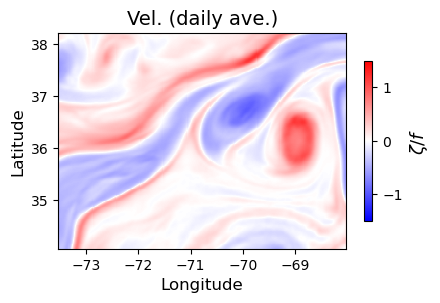

In [54]:
fig, ax = plt.subplots(figsize=(4.5,3.5))
fig.set_tight_layout(True)

im = ax.pcolormesh(hycom_grid.qlon.isel(lat=slice(2,-2),lon=slice(2,-2)), 
                   hycom_grid.qlat.isel(lat=slice(2,-2),lon=slice(2,-2)),
                   (vor.isel(time=2)/hycomfq.data).isel(latG=slice(2,-2),lonG=slice(2,-2)), 
                   rasterized=True,
                   cmap='bwr', vmax=1.5, vmin=-1.5)

ax.set_aspect('equal')

ax.set_title(r"Vel. (daily ave.)", fontsize=14)

ax.set_ylabel(r"Latitude", fontsize=12)
ax.set_xlabel(r"Longitude", fontsize=12)

cbar0 = fig.colorbar(im, ax=ax, shrink=.5)
cbar0.set_label(r"$\zeta/f$", fontsize=13)

plt.savefig(op.join(sdir,'Figs/HYCOM50-UVvort.pdf'))

In [42]:
vbins = np.linspace(-4e0,4e0,40)
sbins = np.linspace(0,4e0,20)
hist = xhist((str / hycomfq.data
             ).isel(time=slice(2,-2),latG=slice(2,-2),lonG=slice(2,-2)
                     ).rename('strain').chunk({'time':10,'latG':-1,'lonG':-1}), 
               (vor / hycomfq.data
               ).isel(time=slice(2,-2),latG=slice(2,-2),lonG=slice(2,-2)
                     ).rename('vort').chunk({'time':10,'latG':-1,'lonG':-1}), 
               bins=[sbins, vbins], density=True
              ).compute()

/tmp/ipykernel_266445/1254533483.py:4: UserWarning: Log scale: values of z <= 0 have been masked
  im = ax.contourf(hist.vort_bin,
/tmp/ipykernel_266445/1254533483.py:12: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in im.collections:


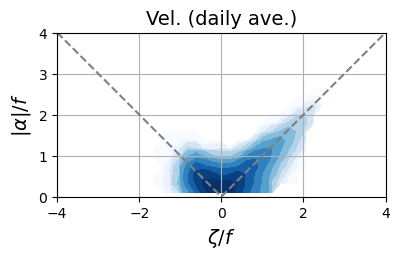

In [52]:
fig, ax = plt.subplots(figsize=(4.1,3.1))
fig.set_tight_layout(True)

im = ax.contourf(hist.vort_bin,
                 hist.strain_bin,
                 hist, 
                 cmap='Blues', locator=ticker.LogLocator(), 
                 norm=clr.LogNorm(), levels=np.logspace(-4,0,9),
                 extend='both'
#                       rasterized=True
               )
for c in im.collections:
    c.set_rasterized(True)

ax.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
ax.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')

ax.set_xlim([-4,4])
ax.set_ylim([0,4])

ax.set_title(r"Vel. (daily ave.)", fontsize=14)
ax.set_xlabel(r"$\zeta/f$", fontsize=14)
ax.set_ylabel(r"$|\alpha|/f$", fontsize=14)

ax.grid(True)
ax.set_aspect('equal')

# cbar = fig.colorbar(im, orientation='horizontal', ax=ax, shrink=.8, 
#                     ticks=[1e-4,1e-3,1e-2,1e-1,1e0])

plt.savefig(op.join(sdir,'Figs/vort-strain-HYCOM50UVjointPDF.pdf'))